In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import dash
from dash import html
from dash import dcc
from dash.dependencies import Input,Output, State
import plotly.graph_objects as go
import plotly.express as px
from dash import no_update

%matplotlib inline

In [15]:
#Get list of active players
players_df=pd.read_html('https://www.basketball-reference.com/leagues/NBA_2023_per_game.html')[0]
players_df=players_df[players_df['Player']!='Player']
players_df=players_df.iloc[:,1:5]
players_df.set_index('Player',inplace=True)
players_df.head(5)

,Pos,Age,Tm
Player,,,
Precious Achiuwa,C,23,TOR
Steven Adams,C,29,MEM
Bam Adebayo,C,25,MIA
Ochai Agbaji,SG,22,UTA
Santi Aldama,PF,22,MEM


In [16]:
#Get links for all active players to be used in querying
urls = 'https://www.basketball-reference.com/leagues/NBA_2023_per_game.html'
grab = requests.get(urls)
soup = BeautifulSoup(grab.text, 'html.parser')
soup=soup.find('table')

links=[]

for link in soup.find_all("a"):
    data = link.get('href')
    if data[:9] =='/players/'and data[-5:]=='.html':
        url='https://www.basketball-reference.com'+data
        links.append(url)

players_df['Link']=links

In [17]:
print('Unique links: ',players_df['Link'].nunique())
print('Unique Players: ',players_df.index.nunique())

Unique links:  488
Unique Players:  488


In [643]:
#Creating player class to inherit attributes and functions
player_queries_standard=[]
player_queries_advanced=[]
formatted_player_queries_standard=[]
formatted_player_queries_advanced=[]


positions=['PG','SG','SF','PF','C']

class Player:
    
    def __init__(self,name):
        self.name=name
        global player_queries_standard, player_queries_advanced, formatted_player_queries_standard, formatted_player_queries_advanced
        if len(player_queries_standard)==0:
            queries=self.get_reports()
            player_queries_standard=queries[0]
            player_queries_advanced=queries[1]
            formatted_player_queries_standard=Player(self.name).format_per_game('Standard')
            formatted_player_queries_advanced=Player(self.name).format_per_game('Advanced')
        elif name not in player_queries_standard['Player Name'].to_list():
            queries=self.get_reports()
            player_queries_standard=pd.concat([player_queries_standard,queries[0]],axis=0)
            player_queries_advanced=pd.concat([player_queries_advanced,queries[1]],axis=0)
            formatted_player_queries_standard=pd.concat([formatted_player_queries_standard,Player(self.name).format_per_game('Standard')],axis=0)
            formatted_player_queries_advanced=pd.concat([formatted_player_queries_advanced,Player(self.name).format_per_game('Advanced')],axis=0)
            
    def __str__(self):
        name=self.name
        pos=self.get_position()
        age=self.get_age()
        tm=self.get_team()
        
        return "Player: {}, Position: {}, Age: {}, Most Recent Team: {}".format(name,pos,age,tm)
    
    def get_info(self,field):
        global player_queries_standard
        df=player_queries_standard[player_queries_standard['Player Name']==self.name]
        
        most_recent=df[df['Season']=='Career'].index.to_numpy().sum()-1
        
        return df.loc[most_recent][field]
    
    def get_player_url(self):
        val=players_df.loc[self.name]['Link']
        
        if type(val) is str:
            return val
        else:
            return val[0]
    
    def get_age(self):
        return self.get_info('Age')
    
    def get_position(self):
        return self.get_info('Pos')
    
    def get_positions(self,df):
        global positions
        player_positions=df['Pos'].dropna().apply(lambda x: x.replace(",","|")).unique()
        all_positions=[]
        
        for i in player_positions:
            if i not in all_positions:
                if '|' not in i:
                    all_positions.append(i)
                else:
                    vals=i.split('|')
                    for sub_val in vals:
                        if sub_val not in all_positions:
                            all_positions.append(i)
        return all_positions
    
    
    def get_team(self):
        return self.get_info('Tm')
    
    def get_reports(self):
        global positions
        req=requests.get(self.get_player_url()).text
        orig_soup=BeautifulSoup(req,'html.parser')
        standard_soup=orig_soup.find(id='div_per_game')
        standard_table=standard_soup.find_all('table')
        standard_df = pd.read_html(str(standard_table))[0]
        
        unique_positions=self.get_positions(standard_df)
        
        for pos in positions:
            if pos in unique_positions:
                standard_df[pos]=True
            else:
                standard_df[pos]=False
                
        standard_df['Player Name']=self.name
  
        advanced_soup=orig_soup.find(id='div_advanced')
        advanced_table=advanced_soup.find_all('table')
        advanced_df = pd.read_html(str(advanced_table))[0]
        advanced_df[positions]=standard_df[positions]
        advanced_df['Player Name']=self.name
        standard_df=standard_df.apply(pd.to_numeric,errors='ignore')
        advanced_df=advanced_df.apply(pd.to_numeric,errors='ignore')
        return standard_df, advanced_df
    
    def format_per_game(self,report_type):
        global player_queries_standard, player_queries_advanced
        
        if report_type=='Standard':
            df=player_queries_standard
        elif report_type=='Advanced':
            df=player_queries_advanced
            
        df=df[df['Player Name']==self.name]
        
        df=df.dropna(axis=1, how='all')
        
        #Getting rid of overseas data
        df=df[df['Lg']=='NBA']
        
        #Ensuring only seasons being included in dataframe
        
        df=df.iloc[0:df.query('Season == "Career"').index[0]]
        
        #Ensuring that all player data per season is consolidated into one row (no splits across teams)
        multi_team_df=df.copy().groupby('Season').count()['Tm']
        df=df[df.apply(lambda x: True if int(multi_team_df.loc[x['Season']])==1 or x['Tm']=='TOT'
              else False
            ,axis=1)]
        return df.apply(pd.to_numeric,errors='ignore')
    
    def get_formatted_per_game(self,report_type):
        global positions, formatted_player_queries_standard, formatted_player_queries_advanced
        
        if report_type=='Standard':
            df=formatted_player_queries_standard
        elif report_type=='Advanced':
            df=formatted_player_queries_advanced
            
        return df[df['Player Name']==self.name]
        
    
    def get_full_peer_group(self):
        global formatted_player_queries_advances, positions
        player_age=self.get_age()

        if player_age<35:
            comparables_df=formatted_player_queries_advanced[formatted_player_queries_advanced['Age']>player_age]
        else:
            comparables_df=formatted_player_queries_advanced.copy()

        positions_array=self.get_formatted_per_game('Advanced')[positions].iloc[0]
        positions_array=positions_array[positions_array== True].index

        players_array=comparables_df[comparables_df[positions_array].sum(axis=1)>0]['Player Name'].unique()

        return players_array
    
    def get_top_5_cluster(self):
        global ws_df
        comparable_list=self.get_full_peer_group()
        comparable_df=ws_df.copy()
        player_name=self.name
        comparable_df=comparable_df.drop(player_name)
        comparable_df=comparable_df[comparable_df.index.isin(comparable_list)]

        player_age=int(self.get_age())
        prediction_list=ws_df.loc[player_name,:player_age]
        prediction_list=np.array(prediction_list).reshape(1,-1)

        min_age=int(ws_df.columns[0])
        x_range=list(range(min_age,player_age+1))
        X=comparable_df[x_range]
        Y=comparable_df['Career']

        Clus_dataSet = StandardScaler().fit_transform(X)

        k_means = KMeans(init = "k-means++", n_clusters = 10, n_init = 20)
        k_means.fit(X)
        labels=k_means.labels_
        comparable_df['label']=labels

        cluster_num=k_means.predict(prediction_list).sum()

        player_cluster=comparable_df[comparable_df['label']==cluster_num].index.to_list()
        player_cluster_df=comparable_df.loc[player_cluster,:player_age]

        player_cluster_arr=np.array(player_cluster_df)
        base_player_arr=np.array(ws_df.loc[player_name,:player_age])

        dists=[]

        for comp_player in player_cluster_arr:
            sum_sq = np.sum(np.square(base_player_arr - comp_player))
            if len(dists)==0:
                dists=[sum_sq]
            else:
                dists.append(sum_sq)

        player_cluster_df['Distance']=dists
        top_5_neigh=player_cluster_df.sort_values(by='Distance',axis=0,ascending=True).head(5).index.to_list()

        return top_5_neigh


In [458]:
#Getting unique list of players to be used in dash
unique_players=players_df.index.sort_values().unique().tolist()
all_players_choices=choices=[{'label':i, 'value':i} for i in unique_players]

In [644]:
import time


for player in unique_players:
    
    if len(player_queries_standard)==0:
        print(Player(player))
    elif player not in player_queries_standard['Player Name'].to_list():
        time.sleep(1.75)
        print(Player(player))

Player: A.J. Green, Position: SG, Age: 23.0, Most Recent Team: MIL
Player: A.J. Lawson, Position: SG, Age: 22.0, Most Recent Team: MIN


KeyboardInterrupt: 

In [524]:
formatted_player_queries_standard.to_csv('12.20.21 Formatted Standard Queries.csv')
player_queries_standard.to_csv('12.20.21 Unformatted Standard Queries.csv')
formatted_player_queries_advanced.to_csv('12.20.21 Formatted Advanced Queries.csv')
player_queries_advanced.to_csv('12.20.21 Unformatted Advanced Queries.csv')

In [645]:
formatted_player_queries_standard=pd.read_csv('12.20.21 Formatted Standard Queries.csv')
player_queries_standard=pd.read_csv('12.20.21 Unformatted Standard Queries.csv')
formatted_player_queries_advanced=pd.read_csv('12.20.21 Formatted Advanced Queries.csv')
player_queries_advanced=pd.read_csv('12.20.21 Unformatted Advanced Queries.csv')

In [29]:
formatted_player_queries_standard=[]
formatted_player_queries_advanced=[]

for player in unique_players:
    if len(formatted_player_queries_standard)==0:
        formatted_player_queries_standard=Player(player).get_formatted_per_game('Standard')
        formatted_player_queries_advanced=Player(player).get_formatted_per_game('Advanced')
    else:
        formatted_player_queries_standard=pd.concat([formatted_player_queries_standard,Player(player).get_formatted_per_game('Standard')],axis=0)
        formatted_player_queries_advanced=pd.concat([formatted_player_queries_advanced,Player(player).get_formatted_per_game('Advanced')],axis=0)

In [32]:
p1=Player('LeBron James')
p2=Player('Khris Middleton')
p3=Player('Santi Aldama')
p4=Player('RJ Barrett')
p5=Player('Derrick Rose')

In [33]:
print(p1)
print(p2)
print(p3)
print(p4)
print(p5)

Player: LeBron James, Position: PF, Age: 38.0, Most Recent Team: LAL
Player: Khris Middleton, Position: SF, Age: 31.0, Most Recent Team: MIL
Player: Santi Aldama, Position: PF, Age: 22.0, Most Recent Team: MEM
Player: RJ Barrett, Position: SG, Age: 22.0, Most Recent Team: NYK
Player: Derrick Rose, Position: PG, Age: 34.0, Most Recent Team: NYK


In [34]:
p7.get_formatted_per_game('Standard')

,Season,Age,Tm,Lg,Pos,G,GS,MP,FG,FGA,...,STL,BLK,TOV,PF,PTS,PG,SG,SF,C,Player Name
0,2008-09,20,CHI,NBA,PG,81,80,37.0,7.1,14.9,...,0.8,0.2,2.5,False,16.8,True,False,False,False,Derrick Rose
1,2009-10,21,CHI,NBA,PG,78,78,36.8,8.6,17.6,...,0.7,0.3,2.8,False,20.8,True,False,False,False,Derrick Rose
2,2010-11,22,CHI,NBA,PG,81,81,37.4,8.8,19.7,...,1.0,0.6,3.4,False,25.0,True,False,False,False,Derrick Rose
3,2011-12,23,CHI,NBA,PG,39,39,35.3,7.7,17.8,...,0.9,0.7,3.1,False,21.8,True,False,False,False,Derrick Rose
5,2013-14,25,CHI,NBA,PG,10,10,31.1,5.8,16.4,...,0.5,0.1,3.4,False,15.9,True,False,False,False,Derrick Rose
6,2014-15,26,CHI,NBA,PG,51,51,30.0,6.6,16.4,...,0.7,0.3,3.2,False,17.7,True,False,False,False,Derrick Rose
7,2015-16,27,CHI,NBA,PG,66,66,31.8,6.8,15.9,...,0.7,0.2,2.7,False,16.4,True,False,False,False,Derrick Rose
8,2016-17,28,NYK,NBA,PG,64,64,32.5,7.2,15.3,...,0.7,0.3,2.3,False,18.0,True,False,False,False,Derrick Rose
9,2017-18,29,TOT,NBA,PG,25,7,16.8,3.2,7.4,...,0.3,0.2,1.4,False,8.4,True,False,False,False,Derrick Rose
12,2018-19,30,MIN,NBA,PG,51,13,27.3,7.1,14.8,...,0.6,0.2,1.6,False,18.0,True,False,False,False,Derrick Rose


In [35]:
p1.get_formatted_per_game('Advanced')

,Season,Age,Tm,Lg,Pos,G,MP,PER,TS%,3PAr,...,OBPM,DBPM,BPM,VORP,PG,SG,SF,PF,C,Player Name
0,2003-04,19,CLE,NBA,SG,79,3122,18.3,0.488,0.145,...,2.3,-0.6,1.7,2.9,True,True,True,True,False,LeBron James
1,2004-05,20,CLE,NBA,SF,80,3388,25.7,0.554,0.183,...,7.0,1.7,8.6,9.1,True,True,True,True,False,LeBron James
2,2005-06,21,CLE,NBA,SF,79,3361,28.1,0.568,0.208,...,7.5,1.6,9.1,9.4,True,True,True,True,False,LeBron James
3,2006-07,22,CLE,NBA,SF,78,3190,24.5,0.552,0.191,...,5.9,2.2,8.1,8.1,True,True,True,True,False,LeBron James
4,2007-08,23,CLE,NBA,SF,75,3027,29.1,0.568,0.219,...,8.2,2.6,10.9,9.8,True,True,True,True,False,LeBron James
5,2008-09,24,CLE,NBA,SF,81,3054,31.7,0.591,0.238,...,9.5,3.7,13.2,11.8,True,True,True,True,False,LeBron James
6,2009-10,25,CLE,NBA,SF,76,2966,31.1,0.604,0.253,...,9.1,2.8,11.8,10.3,True,True,True,True,False,LeBron James
7,2010-11,26,MIA,NBA,SF,79,3063,27.3,0.594,0.188,...,6.3,1.8,8.1,7.8,True,True,True,True,False,LeBron James
8,2011-12,27,MIA,NBA,SF,62,2326,30.7,0.605,0.127,...,8.2,2.7,10.9,7.6,True,True,True,True,False,LeBron James
9,2012-13,28,MIA,NBA,PF,76,2877,31.6,0.64,0.188,...,9.3,2.4,11.7,9.9,True,True,True,True,False,LeBron James


In [36]:
rosters_df=[]
class Team():
    def __init__(self,name):
        global rosters_df
        self.name=name
        self.url='https://www.basketball-reference.com/teams/'+name+'/2023.html'
        if len(rosters_df)==0:
            rosters_df=self.get_rosters()
        elif name not in rosters_df['Tm'].tolist():
            this_roster=self.get_rosters()
            rosters_df=pd.concat([rosters_df,this_roster],axis=0)
            
    def get_rosters(self):
        req=requests.get(self.url).text
        soup=BeautifulSoup(req,'html.parser')
        soup=soup.find(id='div_roster')
        table=soup.find_all('table')
        df = pd.read_html(str(table))[0]
        df['Player']=df['Player'].apply(lambda x: x.replace(' (TW)',''))
        df['Tm']=self.name
        df['Link']=self.get_player_links()
        df=df.apply(pd.to_numeric,errors='ignore')
        return df
    
    def get_roster(self):
        return rosters_df[rosters_df['Tm']==self.name]
    
    def get_player_links(self):
        grab = requests.get(self.url)
        soup = BeautifulSoup(grab.text, 'html.parser')
        soup=soup.find('table')

        links=[]

        for link in soup.find_all("a"):
            data = link.get('href')
            if data[:9] =='/players/'and data[-5:]=='.html':
                url='https://www.basketball-reference.com'+data
                links.append(url)
        return links


In [37]:
t1=Team('NYK')
t2=Team('BRK')

In [38]:
t1.get_roster()

,No.,Player,Pos,Ht,Wt,Birth Date,Unnamed: 6,Exp,College,Tm,Link
0,30,Julius Randle,PF,6-8,250,"November 29, 1994",us,8,Kentucky,NYK,https://www.basketball-reference.com/players/r...
1,11,Jalen Brunson,PG,6-1,190,"August 31, 1996",us,4,Villanova,NYK,https://www.basketball-reference.com/players/b...
2,9,RJ Barrett,SG,6-6,214,"June 14, 2000",ca,3,Duke,NYK,https://www.basketball-reference.com/players/b...
3,5,Immanuel Quickley,PG,6-3,190,"June 17, 1999",us,2,Kentucky,NYK,https://www.basketball-reference.com/players/q...
4,55,Isaiah Hartenstein,C,7-0,250,"May 5, 1998",us,4,<NA>,NYK,https://www.basketball-reference.com/players/h...
5,1,Obi Toppin,PF,6-9,220,"March 4, 1998",us,2,Dayton,NYK,https://www.basketball-reference.com/players/t...
6,23,Mitchell Robinson,C,7-0,240,"April 1, 1998",us,4,Western Kentucky,NYK,https://www.basketball-reference.com/players/r...
7,4,Derrick Rose,PG,6-3,200,"October 4, 1988",us,13,Memphis,NYK,https://www.basketball-reference.com/players/r...
8,45,Jericho Sims,C,6-10,245,"October 20, 1998",us,1,Texas,NYK,https://www.basketball-reference.com/players/s...
9,0,Cam Reddish,SF,6-8,218,"September 1, 1999",us,3,Duke,NYK,https://www.basketball-reference.com/players/r...


In [39]:
#Getting unique teamns to be used in Dash
unique_teams=players_df[(players_df['Tm']!='TOT') & (players_df['Tm']!='Tm')]['Tm'].sort_values().unique().tolist()
unique_teams

['ATL',
 'BOS',
 'BRK',
 'CHI',
 'CHO',
 'CLE',
 'DAL',
 'DEN',
 'DET',
 'GSW',
 'HOU',
 'IND',
 'LAC',
 'LAL',
 'MEM',
 'MIA',
 'MIL',
 'MIN',
 'NOP',
 'NYK',
 'OKC',
 'ORL',
 'PHI',
 'PHO',
 'POR',
 'SAC',
 'SAS',
 'TOR',
 'UTA',
 'WAS']

In [40]:
#Adding 'All' to players list so all players including those not in rosters can be queried
unique_teams.insert(0,'ALL')
teams_choices=[{'label':i, 'value':i} for i in unique_teams]

In [41]:
test_player=Player(players_df.index[0])

In [42]:
df=test_player.get_formatted_per_game('Standard')
standard_cols=df.select_dtypes(include=np.number).drop('Age',axis=1).columns.to_list()
standard_cols

['G',
 'GS',
 'MP',
 'FG',
 'FGA',
 'FG%',
 '3P',
 '3PA',
 '3P%',
 '2P',
 '2PA',
 '2P%',
 'eFG%',
 'FT',
 'FTA',
 'FT%',
 'ORB',
 'DRB',
 'TRB',
 'AST',
 'STL',
 'BLK',
 'TOV',
 'PTS']

In [43]:
df=test_player.get_formatted_per_game('Advanced')
advanced_cols=df.select_dtypes(include=np.number).drop('Age',axis=1).columns.to_list()
advanced_cols

['G',
 'MP',
 'PER',
 'TS%',
 '3PAr',
 'FTr',
 'ORB%',
 'DRB%',
 'TRB%',
 'AST%',
 'STL%',
 'BLK%',
 'TOV%',
 'USG%',
 'OWS',
 'DWS',
 'WS',
 'WS/48',
 'OBPM',
 'DBPM',
 'BPM',
 'VORP']

In [539]:
#updated
app=dash.Dash(__name__)

#need two side by side dropdowns for team and player
app.config.suppress_callback_exceptions = True


app.layout = html.Div(children=[ 
    #Header, Team, and Player Dropdown here
    html.Div(children=[
    html.H1('Basketball Reference Performance Visualizer', 
            style={'textAlign': 'center',
                   'color': '#503D36',
                   'font-size': 24}),
    dcc.Dropdown(id='team-dropdown',
                 options=[{'label':i, 'value':i} for i in unique_teams],
                 value='ALL',
                 placeholder="Select a Team Gere",
                 searchable=True, style=dict(width='50%')
                ),
    dcc.Dropdown(id='player-dropdown',
                 options=[{'label':i, 'value':i} for i in unique_players],
                 value=unique_players[0],
                 placeholder="Select a Player Here",
                 searchable=True, style=dict(width='50%')
                ),
    html.Br()
    ]),
    
    #Standard Statistics Dropdown and chart here
    html.Div(children=[
        html.H2('Standard Statistics:', style={'margin-right': '2em'}),
        
        dcc.Dropdown(id='standard-dropdown',
                 options=[{'label':i, 'value':i} for i in standard_cols],
                 value='PTS',
                 placeholder="Select a Standard Statistic Here",
                 searchable=True
                ),
    
    html.Br(),
    
    html.Div(dcc.Graph(id='standard-chart', 
                       style={'display': 'flex'})),
    
    html.Br()
    ]),
    
    #Advanced Statistics Dropdown and Chart Here
    
    html.Div(children=[
        html.H2('Advanced Statistics:', style={'margin-right': '2em'}),
        dcc.Dropdown(id='advanced-dropdown',
                 options=[{'label':i, 'value':i} for i in advanced_cols],
                 value='WS',
                 placeholder="Select an Advanced Statistic here",
                 searchable=True
                ),
    
    html.Br(),
    
    html.Div(dcc.Graph(id='advanced-chart', 
                       style={'display': 'flex'}))
    ]),
])

#Callback and Function for Team Dropdown
#Default to first value?
@app.callback([Output(component_id='player-dropdown', component_property='options'),
               Output(component_id='player-dropdown',component_property='value')],
              [Input(component_id='team-dropdown', component_property='value'),
               Input(component_id='player-dropdown', component_property='value')])

def get_player_options(team_value,player_value):
    if team_value=='ALL':
        return all_players_choices, player_value
    else:
        this_team=Team(team_value).get_roster()
        roster=sorted(this_team['Player'].to_list())
        choices=[{'label':i, 'value':i} for i in roster
                if i in unique_players]
        
        if Player(player_value).get_team()==team_value:
            player_result=player_value
        else:
            player_result=roster[0]
            
        return choices, player_result

#Callback for Player dropdown
#Default to first value?
@app.callback(Output(component_id='standard-chart', component_property='figure'),
              [Input(component_id='player-dropdown', component_property='value'),
               Input(component_id='standard-dropdown',component_property='value')])

def get_standard_stats(player_value,stat_value):
    player_stats=Player(player_value).get_formatted_per_game('Standard')
    fig=px.scatter(player_stats,x='Age',y=stat_value,title='{} Career {} Per Game'.format(player_value,stat_value),trendline='lowess')
    fig.update_layout(title_x=0.5)
    return fig

@app.callback(Output(component_id='advanced-chart', component_property='figure'),
              [Input(component_id='player-dropdown', component_property='value'),
               Input(component_id='advanced-dropdown',component_property='value')])

def get_advanced_stats(player_value,stat_value):
    player_stats=Player(player_value).get_formatted_per_game('Advanced')
    fig=px.scatter(player_stats,x='Age',y=stat_value,title='{} Career {} Per Game'.format(player_value,stat_value),trendline='lowess')
    fig.update_layout(title_x=0.5)
    return fig

# Run the app
if __name__ == '__main__':
    app.run_server()

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [20/Dec/2022 18:43:22] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [20/Dec/2022 18:43:23] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [20/Dec/2022 18:43:23] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [20/Dec/2022 18:43:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Dec/2022 18:43:23] "GET /_dash-component-suites/dash/dcc/async-graph.js HTTP/1.1" 200 -
127.0.0.1 - - [20/Dec/2022 18:43:23] "GET /_dash-component-suites/dash/dcc/async-dropdown.js HTTP/1.1" 200 -
127.0.0.1 - - [20/Dec/2022 18:43:23] "GET /_dash-component-suites/dash/dcc/async-plotlyjs.js HTTP/1.1" 200 -
127.0.0.1 - - [20/Dec/2022 18:43:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Dec/2022 18:43:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Dec/2022 18:43:28] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Dec/2022 18:43:28] "POST /_dash-update-component HTTP/1.

ATL


127.0.0.1 - - [20/Dec/2022 18:45:16] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Dec/2022 18:45:16] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Dec/2022 18:45:16] "POST /_dash-update-component HTTP/1.1" 200 -


ATL


127.0.0.1 - - [20/Dec/2022 18:45:18] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Dec/2022 18:45:18] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Dec/2022 18:45:18] "POST /_dash-update-component HTTP/1.1" 200 -


ATL


127.0.0.1 - - [20/Dec/2022 18:45:26] "POST /_dash-update-component HTTP/1.1" 200 -


In [358]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [244]:
test_player=Player('RJ Barrett')

In [348]:
ws_df=formatted_player_queries_advanced.copy()
last_season=sorted(ws_df['Season'].to_list())[-1]
games_played_ratio=82/(ws_df[ws_df['Season']==last_season]['G'].max())
games_played_ratio

ws_df['WS']=ws_df.apply(lambda x: x['WS']*games_played_ratio if x['Season']==last_season
            else x['WS'],axis=1)
ws_df=ws_df.pivot(index='Player Name',columns='Age',values='WS')
ws_df=ws_df.replace(np.nan,0)
ws_df['Career']=ws_df.sum(axis=1)

In [349]:
ws_df

Age,19,20,21,22,23,24,25,26,27,28,...,34,35,36,37,38,39,40,41,42,Career
Player Name,,,,,,,,,,,,,,,,,,,,,
A.J. Green,0.00000,0.0,0.00000,0.00000,0.76875,0.0,0.000,0.0000,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.76875
A.J. Lawson,0.00000,0.0,0.00000,0.00000,0.00000,0.0,0.000,0.0000,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
AJ Griffin,2.30625,0.0,0.00000,0.00000,0.00000,0.0,0.000,0.0000,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.30625
Aaron Gordon,1.00000,5.4,3.70000,2.90000,5.10000,3.7,1.900,5.2000,6.91875,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.81875
Aaron Holiday,0.00000,0.0,0.00000,0.90000,2.10000,0.2,1.500,1.5375,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.23750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zach Collins,0.00000,0.6,2.90000,0.30000,0.00000,1.2,1.025,0.0000,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.02500
Zach LaVine,-0.70000,2.6,3.00000,0.30000,2.80000,4.0,5.900,5.8000,2.56250,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.26250
Zeke Nnaji,0.00000,0.9,1.80000,0.76875,0.00000,0.0,0.000,0.0000,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.46875


In [405]:
def get_peer_group(this_player):
    player_age=this_player.get_age()
    
    if player_age<35:
        comparables_df=formatted_player_queries_advanced[formatted_player_queries_advanced['Age']>player_age]
    else:
        comparables_df=formatted_player_queries_advanced.copy()
    
    positions_array=this_player.get_formatted_per_game('Advanced')[positions].iloc[0]
    positions_array=positions_array[positions_array== True].index
    
    players_array=comparables_df[comparables_df[positions_array].sum(axis=1)>0]['Player Name'].unique()
    
    return players_array

In [631]:
def get_player_cluster(this_player):
    comparable_list=this_player.get_peer_group()
    comparable_df=ws_df.copy()
    comparable_df=comparable_df.drop(this_player.name)
    comparable_df=comparable_df[comparable_df.index.isin(comparable_list)]
    
    player_age=int(this_player.get_age())
    prediction_list=ws_df.loc[this_player.name,:player_age]
    prediction_list=np.array(prediction_list).reshape(1,-1)
    
    min_age=int(ws_df.columns[0])
    x_range=list(range(min_age,player_age+1))
    X=comparable_df[x_range]
    Y=comparable_df['Career']

    Clus_dataSet = StandardScaler().fit_transform(X)
    
    k_means = KMeans(init = "k-means++", n_clusters = 10, n_init = 12)
    k_means.fit(X)
    labels=k_means.labels_
    comparable_df['label']=labels
    
    cluster_num=k_means.predict(prediction_list).sum()
    
    player_cluster=comparable_df[comparable_df['label']==cluster_num].index.to_list()
    player_cluster_df=comparable_df.loc[player_cluster,:player_age]
    
    player_cluster_arr=np.array(player_cluster_df)
    base_player_arr=np.array(ws_df.loc[this_player.name,:player_age])
    
    dists=[]
    
    for comp_player in player_cluster_arr:
        sum_sq = np.sum(np.square(base_player_arr - comp_player))
        if len(dists)==0:
            dists=[sum_sq]
        else:
            dists.append(sum_sq)
    
    player_cluster_df['Distance']=dists
    top_5_neigh=player_cluster_df.sort_values(by='Distance',axis=0,ascending=True).head(5).index.to_list()
    
    return top_5_neigh
    
    

In [630]:
test_player=Player('Donovan Mitchell')
get_player_cluster(test_player)

['Mike Conley', 'John Wall', 'DeMar DeRozan', 'Klay Thompson', 'Kemba Walker']

In [597]:
comp_players_df=ws_df.loc[get_player_cluster(Player('RJ Barrett')),:22]
comp_players=np.array(comp_players_df)
base_player=np.array(ws_df.loc["RJ Barrett",:22])
base_player

array([-0.5   ,  4.1   ,  2.3   ,  2.5625])

In [598]:
vals=[]
for comp_player in comp_players:
    sum_sq = np.sum(np.square(base_player - comp_player))
    if len(vals)==0:
        vals=[sum_sq]
    else:
        vals.append(sum_sq)
        

In [605]:
comp_players_df['Distance']=vals
comp_players_df.sort_values(by='Distance',axis=0,ascending=True).head(5).index

Index(['Lauri Markkanen', 'Marcus Smart', 'Aaron Gordon', 'Jrue Holiday',
       'Andrew Wiggins'],
      dtype='string', name='Player Name')

In [603]:
base_player

array([-0.5   ,  4.1   ,  2.3   ,  2.5625])

In [435]:
test_df=Player('Dejounte Murray').get_formatted_per_game('Standard').convert_dtypes()

In [445]:
test_df=test_df.apply(pd.to_numeric,errors='ignore')
test_df.dtypes

Season          object
Age              Int64
Tm              object
Lg              object
Pos             object
G                int64
GS               int64
MP             float64
FG             float64
FGA            float64
FG%            float64
3P             float64
3PA            float64
3P%            float64
2P             float64
2PA            float64
2P%            float64
eFG%           float64
FT             float64
FTA            float64
FT%            float64
ORB            float64
DRB            float64
TRB            float64
AST            float64
STL            float64
BLK            float64
TOV            float64
PF             boolean
PTS            float64
PG             boolean
SG             boolean
SF             boolean
C              boolean
Player Name     object
dtype: object

In [538]:
Player('Dejounte Murray').get_formatted_per_game('Standard').dtypes

Unnamed: 0       int64
Season          object
Age            float64
Tm              object
Lg              object
Pos             object
G              float64
GS             float64
MP             float64
FG             float64
FGA            float64
FG%            float64
3P             float64
3PA            float64
3P%            float64
2P             float64
2PA            float64
2P%            float64
eFG%           float64
FT             float64
FTA            float64
FT%            float64
ORB            float64
DRB            float64
TRB            float64
AST            float64
STL            float64
BLK            float64
TOV            float64
PF                bool
PTS            float64
PG                bool
SG                bool
SF                bool
C                 bool
Player Name     object
dtype: object

In [541]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

In [547]:

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 20)

this_player=Player('RJ Barrett')
comparable_list=this_player.get_peer_group()
comparable_df=ws_df.copy()
comparable_df=comparable_df.drop(this_player.name)
comparable_df=comparable_df[comparable_df.index.isin(comparable_list)]

player_age=int(this_player.get_age())
prediction_list=ws_df.loc[this_player.name,:player_age]
prediction_list=np.array(prediction_list).reshape(1,-1)

min_age=int(ws_df.columns[0])
x_range=list(range(min_age,player_age+1))
X=comparable_df[x_range]
Y=comparable_df['Career']

Clus_dataSet = StandardScaler().fit_transform(X)

#num_clusts=len(comparable_df.index)//5
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
  
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

AttributeError: module 'matplotlib.pyplot' has no attribute 'fig'

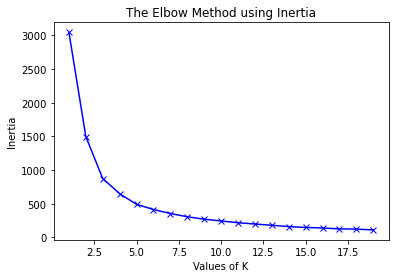

In [552]:

plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.fig(figsize=(12,6))
plt.show()

In [551]:

for key, val in mapping2.items():
    print(f'{key} : {val}')

1 : 3046.0038613861416
2 : 1496.8616496324203
3 : 874.2299950546135
4 : 649.1018210047171
5 : 491.112631909154
6 : 414.27744444444386
7 : 354.8841111111107
8 : 306.3130056017793
9 : 270.5158294429973
10 : 244.40477564464516
11 : 218.27694368131841
12 : 198.58191150580245
13 : 180.34975188700213
14 : 160.77144992864172
15 : 148.2338449063837
16 : 139.50232969687946
17 : 126.80787268416137
18 : 123.03783730158737
19 : 111.25595817669165


In [661]:
Player('RJ Barrett').get_top_5_cluster()

['Lauri Markkanen',
 'Marcus Smart',
 'DeMar DeRozan',
 'Brandon Ingram',
 'Tyler Herro']